In [1]:
from pathlib import Path
from collections import defaultdict

import pylab as p
from tqdm import tqdm
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch_geometric as pyg
import networkx as nx

import extension as ext
from extension import utils
from tree_segmentation.tree_2d_segmentation import TreeStructure, TreeData, MaskData
from tree_segmentation.tree_3d_segmentation import Tree3D
import tree_segmentation.util as vis_util

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
device = torch.device('cuda')
print(device, torch.cuda.is_available())

cuda True


# 一. 生成大量二维树分割结果

- 给定一个mesh $S=(\mathbf{V}, \mathbf{F})$
- 在制定范围内生成$K$个视角$\{\pi_k\}_{k=1}^{K}$, 每个视角渲染一张图片$I_k$及像素与三角面片间的对应关系$C_k$: $$I_k, C_k = \mathrm{render}(S, \pi_k)$$
- 对每张图片$I_k$进行二维树分割, 得到结果$T^{2d}_k = \{m_j\}_{j=1}^{N_k}$, 其中$N_k$表示第$k$个视角的分割结果的数量
- 汇总所有的分割结果$\{m_i\}_{i=1}^{N}, N=\sum{N_k}$, 第$i$个mask对应的视角为$\pi(i)$

In [3]:
# load 2d segmentation results
root = Path('~/wan_code/segmentation/segment_anything/results/').expanduser()
# save_root = root / '12612b82ea88a8977007b330cacd9453'  # tang_table
# save_root = root / 'c44102ae857d5428fa4e91279f4e43e1'  # table and chairs
save_root = root / 'cbec970966b1cfc31013390074d5de0a'  # chairs
seg_2d_files = sorted(list(save_root.glob('*.data')))
print(f'There are {len(seg_2d_files)} data')
data = [torch.load(filename, map_location='cpu') for filename in seg_2d_files]
print(utils.show_shape(data[0]))

There are 100 data
{'tree_data': {'masks': IntTensor[4, 1024, 1024], 'iou_preds': F32Tensor[17], 'points': F64Tensor[17, 2], 'stability_score': F32Tensor[17], 'boxes': F32Tensor[17, 4], 'area': LongTensor[17], 'parent': IntTensor[18], 'first': IntTensor[18], 'next': IntTensor[18], 'last': IntTensor[18], 'cnt': 17, 'num_samples': IntTensor[18], 'extra': {}}, 'image': numpy((1024, 1024, 3), float32), 'tri_id': IntTensor[1024, 1024], 'Tw2v': F32Tensor[4, 4]}


In [4]:
# load mesh
mesh = torch.load(list(save_root.glob('*.mesh_cache'))[0], map_location=device)
v3 = mesh.v_pos[mesh.f_pos]  # shape: (F, 3, 3)
mesh_area = torch.cross(v3[:, 0] - v3[:, 1], v3[:, 0] - v3[:, 2], dim=-1).norm(dim=-1) * 0.5
print(mesh)
num_faces = mesh.f_pos.shape[0]
print('num faces:', num_faces, mesh_area.shape)
del mesh

Mesh(vertices=42485, faces=84762, tex, nrm, tng, mat=['kd', 'ka', 'ks', 'bsdf', 'name'])
num faces: 84762 torch.Size([84762])


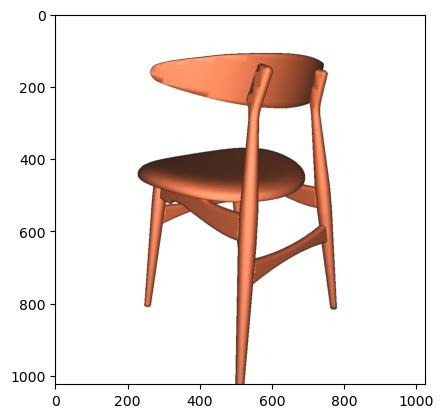

In [5]:
plt.imshow(data[2]['image'].clip(0, 1))

In [6]:
view_indices = []
all_masks = []
all_masks_info = []
all_masks_map = {}
for k in range(len(data)):
    masks = data[k]['tree_data']['masks']
    for i in range(len(masks)):
        if i == 0:
            continue
        for j in masks[i].unique():
            j = j.item()
            if j == 0:
                continue
            all_masks.append(masks[i] == j)
            all_masks_info.append((k, i, j))
            all_masks_map[(k, j)] = len(all_masks) - 1
            view_indices.append(k)
N = len(all_masks)
Lmax = 2 * max(data_i['tree_data']['cnt'] for data_i in data)
view_indices = torch.tensor(view_indices, dtype=torch.long, device=device)
print(f'There are {N} masks, L_max={Lmax}', utils.show_shape(view_indices))

There are 1488 masks, L_max=54 LongTensor[1488]


In [7]:
tri_uni = []
view_masks = torch.zeros((len(data), num_faces + 1), dtype=torch.float, device=device)
for i, item in enumerate(data):
    faces, cnts = item['tri_id'].cuda().unique(return_counts=True)
    faces = faces.long()
    tri_uni.append((faces, cnts))
    view_masks[i, faces] = 1  #cnts.float()
print(view_masks.shape)
assert 0 <= view_indices.min() and view_indices.max() < view_masks.shape[0]

torch.Size([100, 84763])


In [8]:
faces_masks = torch.zeros((N, num_faces + 1), dtype=torch.float, device=device)
for i in range(N):
    k = view_indices[i].item()
    faces, cnts = torch.unique(data[k]['tri_id'][all_masks[i]].cuda(), return_counts=True)
    faces_masks[i][faces.long()] = cnts.float()
    faces_masks[i][tri_uni[k][0]] /= tri_uni[k][1]
faces_masks[:, 0] = 0
print(faces_masks.shape, *faces_masks.aminmax())
print((faces_masks[3, 1:] * mesh_area).sum(), (view_masks[3, 1:] * mesh_area).sum())

torch.Size([1488, 84763]) tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.7688, device='cuda:0') tensor(2.2707, device='cuda:0')


# 二. 建图

A[i, j] = IoU(mask[i], mask[j])

In [9]:
A = torch.zeros((N, N), device=device, dtype=torch.float)
for i in tqdm(range(N)):
    mask = view_masks[view_indices[i]] * view_masks[view_indices]
    mask_i = faces_masks[i] * mask
    mask_j = faces_masks * mask
    inter = ((mask_i * mask_j)[:, 1:] * mesh_area).sum(dim=-1)
    area_i = (mask_i[:, 1:] * mesh_area).sum(dim=-1)
    area_j = (mask_j[:, 1:] * mesh_area).sum(dim=-1)
    A[i] = inter / (area_i + area_j - inter).clamp(1e-7)
print(*A.aminmax())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1488/1488 [00:37<00:00, 39.62it/s]

tensor(0., device='cuda:0') tensor(1., device='cuda:0')


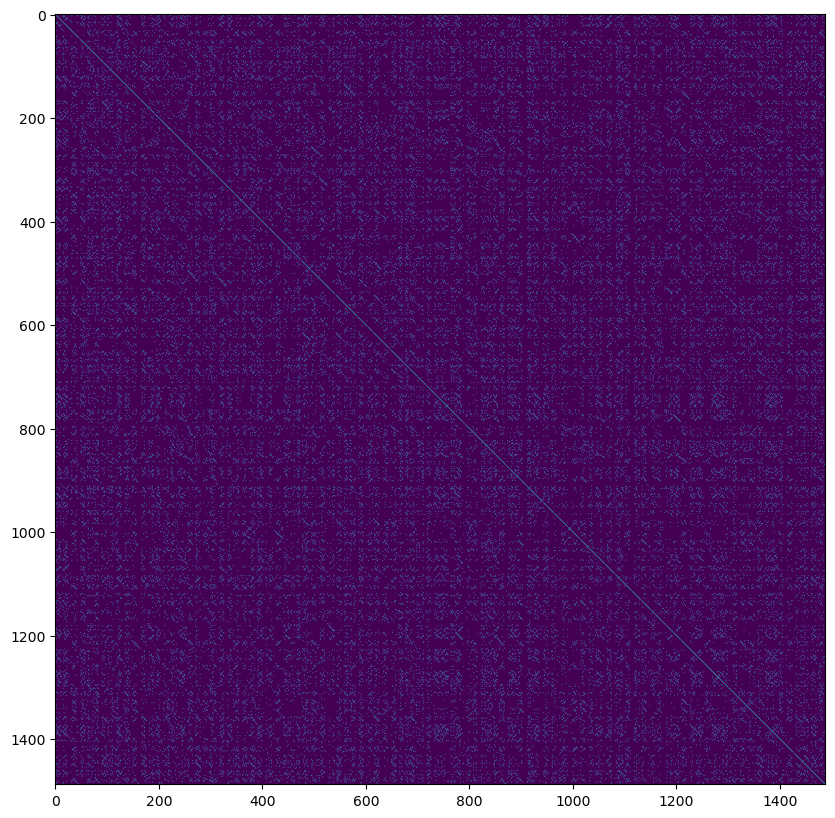

num edges: [407590, 163029, 144153, 129403, 115816, 102813, 89724, 75929, 58916, 32065]


In [10]:
plt.figure(figsize=[10, 10])
plt.imshow(A.detach().cpu().numpy() > 0.8)
plt.show()
print('num edges:', [(A > x / 10).sum().item() for x in range(10)])

In [11]:
# autoencoder: 压缩mask
dF = 256
encoder = nn.Sequential(
    nn.Linear(num_faces, 512),
    nn.GELU(),
    nn.Linear(512, 256),
    nn.GELU(),
    nn.Linear(256, dF)
).cuda()
decoder = nn.Sequential(
    nn.Linear(dF, 256),
    nn.GELU(),
    nn.Linear(256, 512),
    nn.GELU(),
    nn.Linear(512, num_faces)
).cuda()
print('encoder:', encoder, 'params:', sum(param.numel() for param in encoder.parameters()) * 1e-6, 'M')
print('decoder:', decoder, 'params:', sum(param.numel() for param in decoder.parameters()) * 1e-6, 'M')
metric = ext.DictMeter()
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
batch_size = 32
for epoch in range(10000):
    threshold = torch.rand(1, device=device)
    edges = torch.nonzero(A.gt(threshold))
    assert len(edges) > 0
    edges = edges[torch.randint(0, len(edges), (batch_size // 2,))]
    edges = torch.cat([edges, torch.randint(0, N, (batch_size - edges.shape[0], 2), device=device)], dim=0)
    gt = faces_masks[edges.view(-1), 1:]
    # print(utils.show_shape(gt), *gt.aminmax())
    features = encoder(gt)
    # print('features', utils.show_shape(features))

    view_f = encoder(view_masks[:, 1:])
    # print('view_f:', utils.show_shape(view_f))

    mask = view_f[view_indices[edges[:, 0]]] * view_f[view_indices[edges[:, 1]]]
    masked_feat = features.view(batch_size, 2, -1) * mask[:, None]
    # print(utils.show_shape(mask, masked_feat))
    IoU_p = F.cosine_similarity(masked_feat[:, 0], masked_feat[:, 1])
    IoU_gt = A[edges[:, 0], edges[:, 1]]
    # print('IoU', utils.show_shape(IoU_gt, IoU_p))
    loss = F.mse_loss(IoU_p, IoU_gt)

    recon = decoder(torch.cat([features, view_f, masked_feat.view(-1, dF)], dim=0))
    mask = view_masks[view_indices[edges[:, 0]]] * view_masks[view_indices[edges[:, 1]]]
    gt = torch.cat([gt, view_masks[:, 1:], (gt.view(batch_size, 2, -1) * mask[:, None, 1:]).flatten(0, 1)], dim=0)
    # print('recon mask', utils.show_shape(recon, mask, gt))
    reco_loss = F.binary_cross_entropy_with_logits(recon, gt)
    # print('recon', utils.show_shape(recon), reco_loss)
    # print('loss:', loss)
    metric.update({'recon': reco_loss, 'IoU': loss})
    opt.zero_grad()
    (loss + reco_loss * 1.0).backward()
    opt.step()
    if epoch % 100 == 0:
        print(f'epoch[{epoch:4d}], loss: {metric.average}')
        metric.reset()

encoder: Sequential(
  (0): Linear(in_features=84762, out_features=512, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): GELU(approximate='none')
  (4): Linear(in_features=256, out_features=256, bias=True)
) params: 43.595776 M
decoder: Sequential(
  (0): Linear(in_features=256, out_features=256, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): GELU(approximate='none')
  (4): Linear(in_features=512, out_features=84762, bias=True)
) params: 43.680282 M
epoch[   0], loss: recon= 0.693, IoU= 0.474
epoch[ 100], loss: recon= 0.207, IoU= 0.070
epoch[ 200], loss: recon= 0.069, IoU= 0.037
epoch[ 300], loss: recon= 0.047, IoU= 0.034
epoch[ 400], loss: recon= 0.030, IoU= 0.027
epoch[ 500], loss: recon= 0.022, IoU= 0.026
epoch[ 600], loss: recon= 0.020, IoU= 0.025
epoch[ 700], loss: recon= 0.019, IoU= 0.024
epoch[ 800], loss: recon= 0.014, IoU= 0.021
epoch[ 900], loss: recon= 

KeyboardInterrupt: 

In [ ]:
mask_feats = []
for i in range(0, N, batch_size):
    with torch.no_grad():
        mask_feats.append(encoder(faces_masks[i:i + batch_size, 1:]))
mask_feats = torch.cat(mask_feats, dim=0)
with torch.no_grad():
    view_feats = encoder(view_masks[:, 1:])
print(utils.show_shape(mask_feats, view_feats))

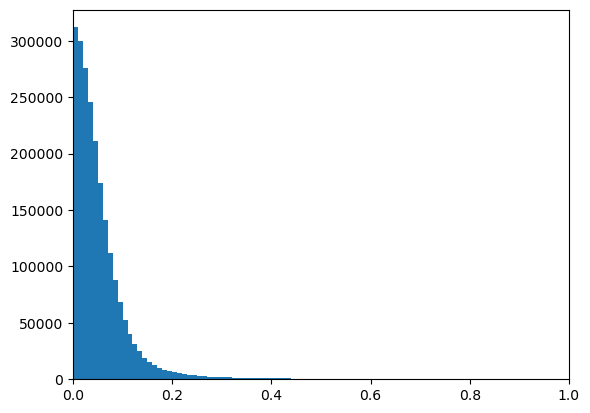

In [72]:
A_ = torch.zeros_like(A)
for i in range(N):
    mask_feat = view_feats[view_indices[i]] * view_feats[view_indices]
    A_[i] = F.cosine_similarity(mask_feats[i] * mask_feat, mask_feats * mask_feat, dim=-1)
# A_[A == 0] = 0
plt.hist((A_ - A).view(-1).abs().cpu().numpy(), bins=100)
plt.xlim(0, 1)
plt.show()

In [ ]:
# plt.figure(figsize=(20, 20))
e = (A > 0.9).nonzero()
G = nx.Graph()
G.add_nodes_from(list(range(N)))
for e1, e2 in e:
    e1, e2 = e1.item(), e2.item()
    if e1 < e2 < N:
        G.add_edge(e1, e2)

In [ ]:
for c in sorted(nx.connected_components(G), key=len, reverse=True):
    print(len(c))
    if len(c) > 10:
        nx.draw_networkx(nx.subgraph(G, c), with_labels=False, node_size=10)
        plt.show()

In [ ]:
results = []
for c in sorted(nx.connected_components(G), key=len, reverse=True):
    if len(c) >= 10:
        temp = torch.zeros(num_faces + 1, device=device)
        for x in c:
            temp += faces_masks[x]
        temp = (temp / len(c)) > 0.5
        results.append(temp)
results = torch.stack(results)
print(utils.show_shape(results))

In [ ]:
view_idx = 20
print(utils.show_shape(results[:, data[view_idx]['tri_id']]))
tree_2d = TreeData(MaskData(masks=results[:, data[view_idx]['tri_id']],
    iou_preds=torch.zeros(results.shape[0], device=device)), device=device)
tree_2d.update_tree()
tree_2d.remove_not_in_tree()
tree_2d.print_tree()
image = data[view_idx]['image'].clip(0, 1)
for i, level in enumerate(tree_2d.get_levels()):
    print(level)
    if i == 0:
        continue
    _masks = tree_2d.data['masks'][level - 1]
    plt.figure(dpi=200)
    plt.subplot(121)
    vis_util.show_masks(image, _masks)
    plt.subplot(122)
    vis_util.show_masks(None, _masks)
    plt.show()


In [25]:
class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=3):
        super().__init__()
        self.conv1 = pyg.nn.GCNConv(in_dim, hidden_dim)
        self.relu = nn.ReLU(True)
        self.conv2 = pyg.nn.GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = self.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [48]:
from graph_network import networks, nocd_utils

X = torch.ones((N, 1), dtype=torch.float, device=device)

hidden_sizes = [128]  # hidden sizes of the GNN
weight_decay = 1e-2  # strength of L2 regularization on GNN weights
dropout = 0.1  # whether to use dropout
batch_norm = True  # whether to use batch norm
lr = 1e-3  # learning rate
balance_loss = True  # whether to use balanced loss

gnn = GCN(X.shape[1], 128, Lmax).to(device)
print(gnn)
AA = A * (A > 0.5)
edge_index = torch.nonzero(AA).T
edge_weight = AA[edge_index[0], edge_index[1]]
print(edge_index.shape, edge_weight.shape)
# adj_norm = gnn.normalize_adj(A)
# AA = A * (A > 0.5)
# deg = (AA > 0).sum(dim=1)
# print(deg)
# assert torch.all(deg > 0)
# deg_sqrt_inv = 1. / deg.sqrt().clamp_min(1e-7)
# adj_norm = AA * deg_sqrt_inv[:, None] * deg_sqrt_inv[None, :]
decoder = networks.BerpoDecoder(N, edge_index.shape[1], balance_loss=balance_loss)
opt = torch.optim.AdamW(gnn.parameters(), lr=lr, weight_decay=0.001)

GCN(
  (conv1): GCNConv(1, 128)
  (relu): ReLU(inplace=True)
  (conv2): GCNConv(128, 54)
)
torch.Size([2, 102813]) torch.Size([102813])


In [49]:
gnn.train()
val_loss = np.inf
validation_fn = lambda: val_loss

# print('adj_norm:', adj_norm.min(), adj_norm.max())
for epoch in range(1000):
    if epoch % 100 == 0:
        with torch.no_grad():
            gnn.eval()
        # Compute validation loss
        Z = F.relu(gnn(X, edge_index, edge_weight))
        val_loss = decoder.loss_full(Z, A)
        print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}')

    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(X, edge_index, edge_weight))

    loss = decoder.loss_full(Z, A)
    # loss += nocd_utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()
    # break

Epoch    0, loss.full = 2.5862
Epoch  100, loss.full = 1.1011
Epoch  200, loss.full = 1.0999
Epoch  300, loss.full = 1.0984
Epoch  400, loss.full = 1.0968
Epoch  500, loss.full = 1.0952
Epoch  600, loss.full = 1.0937
Epoch  700, loss.full = 1.0925
Epoch  800, loss.full = 1.0917
Epoch  900, loss.full = 1.0912


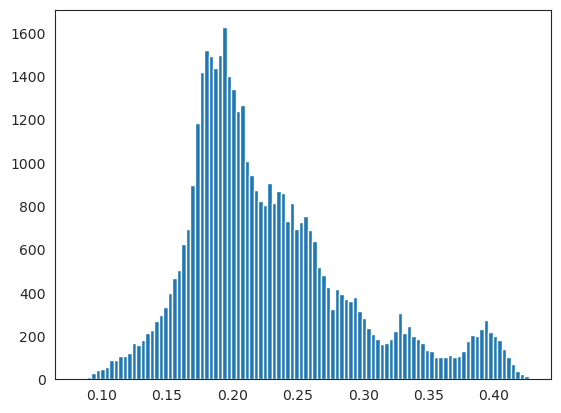

[ 0 10 13]


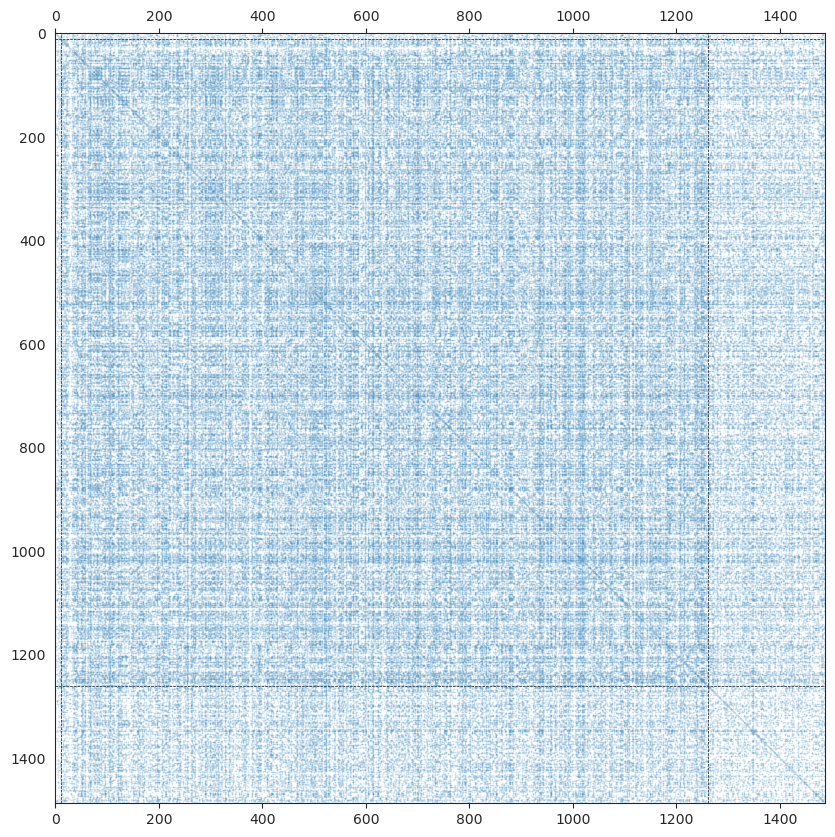

In [51]:
gnn.eval()
thresh = 0.3
with torch.no_grad():
    Z = F.relu(gnn(X, edge_index, edge_weight))
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100)
plt.show()
Z_pred = Z.cpu().detach().numpy() > thresh

plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
print(np.unique(z))
o = np.argsort(z)
nocd_utils.plot_sparse_clustered_adjacency(A.cpu().numpy(), Lmax, z, o, markersize=0.05)

# 二. 三维树分割
将 $\{m_i\}_{i=1}^{N}$ 划分为$L \le L_{max}$($L_{max} = 2\max{N_k}$)个类 $M_l = \{m^l_1, m^l_2, \dots, m^l_{Nm_l}\}$, $M_l$包含的三角面片为:
$$M_l = \{x \mid \frac{\sum{area(x, C_i \cdot m^l_i)}}{\sum{area(x, C_i)}} \ge 0.5\}$$

令$S\in [0, 1]^{L \times N}$表示某个分割结果归属某个类的概率, 则
$$M_l = \{x \mid \frac{1}{\sum_{i \mid x \in C_{\pi(i)}}{S_{li}}} \sum_{i \mid x \in C_{\pi(i)}}{S_{li}\frac{area(x, C_{\pi(i)}\cdot m_i)}{area(x, C_{\pi(i)})} \ge 0.5, x \in \mathbf{F}}\}$$
其中$area(x, C_i) = |\{(h, w) \mid C_i(h, w) = x\}| $表示三角面片$x$在投影$\pi(i)$中的像素的数量

将$M_1, \dots, M_L$ 组成一棵树$\mathbf{T}=\{T_i\}_{i=1}^{L}$, 对于任意结点$i$, 其父节点$p$满足:

$$\arg\max_{p} \{area(M_p \& M_i) \mid In(M_i, M_p) > In(M_p, M_i)\}$$

$In(M_i, M_p) = \frac{area(M_i \& M_p)}{area(M_i)}$表示相交部分在$M_i$中的比例

In [39]:
S = torch.randn((N, Lmax), device=device, requires_grad=True)
Score = torch.randn(Lmax, device=device, requires_grad=True)

# X = torch.ones((N, 1), device=device, dtype=torch.float)
# # gnn = GCN(X.shape[1], 128, Lmax).to(device)
# gnn = pyg.nn.GAT(X.shape[1], 128, 1, Lmax, edge_dim=1).to(device)
# print(gnn)
# AA = A * (A >= 0.5)
# edge_index = torch.nonzero(AA).T
# edge_index = edge_index[:, edge_index[0] != edge_index[1]]
# edge_weight = AA[edge_index[0], edge_index[1]][:, None]
# # print(edge_index[:, 0], edge_weight[0])
# print('edge index/weight:', utils.show_shape(edge_index, edge_weight))

In [33]:
# mask应与对应社区相似
def calc_asssign_score(P: Tensor, Masks: Tensor = None, eps=1e-7):
    mask = view_masks[view_indices]
    if Masks is None:
        Masks = (P.T @ faces_masks) / (P.T @ mask).clamp_min(eps)  # shape: [C, num_faces]
    inter = F.linear(Masks[:, 1:], faces_masks[:, 1:] * mesh_area)  # shape: [C, N], do not need *mask
    # now_area = (Masks[:32, None, 1:] * mask[None, :64, 1:] * mesh_area).sum(dim=-1)
    now_area = F.linear(Masks[:, 1:], mask[:, 1:] * mesh_area)
    # print(inter.shape, now_area.shape, now_area_2.shape, (now_area_2 - now_area).abs().max())
    mask_areas = (faces_masks[:, 1:] * mesh_area).sum(dim=-1)

    dice_loss = 2. * inter / (now_area + mask_areas[None, :]).clamp_min(eps)
    return dice_loss


def calc_loss(P: Tensor, scores: Tensor = None, Masks: Tensor = None, eps=1e-7):
    if scores is None:
        scores = calc_asssign_score(P, Masks, eps)
    return 1. - (scores * P.T).sum(dim=0).mean()


def calc_loss_2(P: Tensor, feats: Tensor = None, eps=1e-7):
    if feats is None:
        feats = P.T @ mask_feats
    masked_feats = feats[:, None] * view_feats[view_indices][None, :]
    return 1 - F.cosine_similarity(masked_feats, mask_feats[None, :], dim=-1).mean()


print('loss:', calc_loss(S.softmax(dim=1)))
# print('loss:', calc_loss_2(S.softmax(dim=1)))

loss: tensor(0.9323, device='cuda:0', grad_fn=<RsubBackward1>)


In [14]:
def loss_2d(P: Tensor, C_scores: Tensor, eps=1e-7):
    # 1. 每个mask选择社区
    c_idx = torch.argmax(P, dim=1)
    print(c_idx.shape, *c_idx.aminmax())
    # 2. 计算每个社区对应的faces
    c_masks = faces_masks.new_zeros((P.shape[1], num_faces + 1))
    print('c_masks:', utils.show_shape(c_masks, c_idx, faces_masks))
    c_masks = torch.scatter_reduce(c_masks, 0, c_idx[:, None].expand_as(faces_masks), faces_masks, reduce='sum')
    print('c_masks:', utils.show_shape(c_masks))
    t = torch.scatter_reduce(
        torch.zeros_like(c_masks),
        0,
        c_idx[:, None].expand_as(faces_masks),
        view_masks[view_indices],
        reduce='sum',
    )
    c_masks = c_masks / t.clamp_min(1e-7)  # shape: [C, nF]
    print(*c_masks.aminmax())
    # 3. 计算mask与对应社区的dice score
    c_masks = c_masks[c_idx]  # shape: [N, nF]
    inter = (c_masks[:, 1:] * faces_masks[:, 1:] * mesh_area).sum(dim=-1)  # shape: [N], do not need *mask
    # now_area = (Masks[:32, None, 1:] * mask[None, :64, 1:] * mesh_area).sum(dim=-1)
    now_area = (c_masks[:, 1:] * view_masks[view_indices, 1:] * mesh_area).sum(dim=-1)
    mask_areas = (faces_masks[:, 1:] * mesh_area).sum(dim=-1)
    dice = 2. * inter / (now_area + mask_areas).clamp_min(eps)  # shape: [C, N]
    print(utils.show_shape(inter, now_area, mask_areas, dice))
    # 4. 计算每个view与所有社区间的关系
    cs_gt = torch.zeros_like(C_scores)
    print('cs_gt', utils.show_shape(cs_gt, view_indices, dice))
    cs_gt = torch.scatter_reduce(cs_gt, 0, c_idx, dice, 'sum')
    print('cs_gt', utils.show_shape(cs_gt))
    return 1 - dice.mean()


print('loss:', loss_2d(S.softmax(dim=1), S.new_zeros(S.shape[1])))

torch.Size([1488]) tensor(0, device='cuda:0') tensor(26, device='cuda:0')
c_masks: F32Tensor[27, 84763], LongTensor[1488], F32Tensor[1488, 84763]
c_masks: F32Tensor[27, 84763]
tensor(0., device='cuda:0') tensor(1., device='cuda:0')
F32Tensor[1488], F32Tensor[1488], F32Tensor[1488], F32Tensor[1488]
cs_gt F32Tensor[27], LongTensor[1488], F32Tensor[1488]
cs_gt F32Tensor[27]
loss: tensor(0.8995, device='cuda:0')


In [15]:
# 减少社区数量
def calc_comm_prob(P: Tensor):
    log_P = torch.log(1 - P)
    view_P = torch.zeros((len(data), P.shape[1]), device=P.device)  # shape: [V, C]
    view_P = torch.scatter_reduce(view_P, 0, view_indices[:, None].expand_as(log_P), log_P, 'sum')  # shape: [V, C]
    view_P = 1 - torch.exp(view_P)  # shape: [V, C]
    return view_P


def reg_num_comm(P: Tensor):
    view_P = calc_comm_prob(P)
    # return view_P.mean(dim=0).abs().sum()
    return view_P.abs().mean()


print(reg_num_comm(S.softmax(dim=1)))

tensor(0.4263, device='cuda:0', grad_fn=<MeanBackward0>)


In [16]:
# 同一视角下的不同mask不属于同一个社区
mask = (view_indices[:, None] == view_indices[None, :]) ^ torch.eye(N, device=device).bool()
same_view_edges = mask.nonzero(as_tuple=True)


def reg_edge_in_same_view(P: Tensor):
    P_uv = (P[same_view_edges[0], :] * P[same_view_edges[1], :]).sum(dim=1)
    return P_uv.mean()


print(reg_edge_in_same_view(S.softmax(dim=1)))


tensor(0.0372, device='cuda:0', grad_fn=<MeanBackward0>)


In [17]:
# 相连的边的特征相似
def edge_similarity(S: Tensor):
    S = F.normalize(S, dim=1)  # shape: [N, C]
    sim = S @ S.T
    return F.mse_loss(sim, A)


print(edge_similarity(S))

tensor(0.0696, device='cuda:0', grad_fn=<MseLossBackward0>)


In [18]:
def recon_loss(P: Tensor, Masks: Tensor = None, k1=-1, k2=-1, eps=1e-7):
    if Masks is None:
        Masks = (P.T @ faces_masks) / (P.T @ view_masks[view_indices]).clamp_min(eps)
    if k1 < 0:
        k1 = torch.randint(0, len(data), (1,)).item()
    if k2 < 0:
        k2 = torch.randint(0, len(data), (1,)).item()
    assert 0 <= k1 < len(data) and 0 <= k2 < len(data)
    view_mask = view_masks[k1].gt(0) * view_masks[k2].gt(0)
    view_mask[0] = 0
    # print('view_mask:', utils.show_shape(view_mask))
    if view_mask.sum() == 0:
        return torch.zeros(1, device=device)
    # print(*Masks.aminmax())
    masks_ = Masks[:, view_mask] * mesh_area[view_mask[1:]]
    # print('masks_', utils.show_shape(masks_), *mesh_area.aminmax())
    inter_ = F.linear(masks_, masks_)
    area = masks_.sum(dim=-1)
    # print(inter_.shape)
    # IoU = inter_ / (area[:, None] + area[None, :] - inter_).clamp_min(eps)  # tree结点 两两间IoU
    IoU = 2 * inter_ / (area[:, None] + area[None, :]).clamp_min(eps)  # tree结点 两两间IoU
    # print(IoU.shape)
    id_1 = torch.nonzero(view_indices.eq(k1))[:, 0]
    id_2 = torch.nonzero(view_indices.eq(k2))[:, 0]
    # print(utils.show_shape(id_1, id_2))
    predictions = (P[id_1, None, :, None] * P[None, id_2, None, :] * IoU).sum(dim=[2, 3])
    # print((P[id_1, None, :, None] * P[None, id_2, None, :]).sum(dim=[2, 3]))
    # print('predictions', utils.show_shape(predictions))
    gt_index = torch.meshgrid(id_1, id_2, indexing='ij')
    # print(utils.show_shape(gt_index))
    IoU_gt = A[gt_index]
    # print('gt:', utils.show_shape(IoU_gt))
    # print(IoU_gt - predictions)
    return F.mse_loss(predictions, IoU_gt)


print(recon_loss(S.softmax(dim=1)))

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


In [45]:
from scipy.optimize import linear_sum_assignment


def community_confidence(scores: Tensor, node_scores: Tensor):
    # print(scores.shape, *scores.aminmax())
    scores = 1. - scores
    losses = 0
    for i in range(len(data)):
        scores_i = scores[:, view_indices == i]
        comm_idx, mask_idx = linear_sum_assignment(scores_i.detach().cpu().numpy())
        # print(comm_idx, mask_idx)
        comm_idx, mask_idx = utils.tensor_to(comm_idx, mask_idx, device=scores.device)
        score_ci = 1 - scores_i[comm_idx, mask_idx]
        # print(score_ci)
        dice_score = 2 * (score_ci * node_scores[comm_idx]).sum() / (node_scores.sum() + scores_i.shape[1])
        losses += 1 - dice_score
    return losses / len(data)


print('community_confidence:', community_confidence(calc_asssign_score(S.softmax(dim=1)), Score))

community_confidence: tensor(0.8779, device='cuda:0', grad_fn=<DivBackward0>)


In [47]:
def loss_fn(S: Tensor, Sn: Tensor, eps=1e-7):
    P = S.softmax(dim=1)  # shape: (N, C)
    Masks = (P.T @ faces_masks) / (P.T @ view_masks[view_indices]).clamp_min(eps)  # shape: [C, num_faces]
    match_score = calc_asssign_score(P, Masks, eps=eps)
    Sn = Sn.sigmoid()
    losses = {
        'cm': calc_loss(P, scores=match_score, Masks=Masks, eps=eps),
        # 'edge': edge_similarity(S),
        'view': reg_edge_in_same_view(P),
        # 'recon': recon_loss(P, Masks),
        'l1': reg_num_comm(P),
        'cc': community_confidence(match_score, Sn)
    }
    return losses

In [ ]:
# nn.init.normal_(S)
# S = torch.randn((N, Lmax), device=device, requires_grad=True)
# Score = torch.randn(Lmax, device=device, requires_grad=True)

In [48]:
opt = torch.optim.Adam([S, Score], lr=1e-3)
# opt = torch.optim.Adam(gnn.parameters(), lr=1e-3)
for epoch in range(5000):
    opt.zero_grad()
    # S = gnn(X, edge_index, edge_attr=edge_weight)
    # print(S.aminmax(), X.aminmax(), edge_weight.aminmax())
    loss_dict = loss_fn(S, Score)
    total_loss = sum(loss_dict.values())
    # print(loss_dict)
    # break
    total_loss.backward()
    opt.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}: total loss={total_loss.item():.6f}, {', '.join(f'{k}={v.item():.6f}' for k, v in loss_dict.items())}")

Epoch 100: total loss=2.151664, cm=0.930887, view=0.018697, l1=0.241515, cc=0.960565
Epoch 200: total loss=2.136812, cm=0.928285, view=0.018897, l1=0.241211, cc=0.948418
Epoch 300: total loss=2.115571, cm=0.923952, view=0.019138, l1=0.240848, cc=0.931633
Epoch 400: total loss=2.087416, cm=0.917230, view=0.019388, l1=0.240474, cc=0.910324
Epoch 500: total loss=2.052604, cm=0.907498, view=0.019611, l1=0.240147, cc=0.885348
Epoch 600: total loss=2.010417, cm=0.894376, view=0.019781, l1=0.239907, cc=0.856352
Epoch 700: total loss=1.962642, cm=0.877715, view=0.019880, l1=0.239785, cc=0.825262
Epoch 800: total loss=1.910314, cm=0.857700, view=0.019885, l1=0.239814, cc=0.792914
Epoch 900: total loss=1.855166, cm=0.834728, view=0.019785, l1=0.240010, cc=0.760643
Epoch 1000: total loss=1.798392, cm=0.809173, view=0.019582, l1=0.240370, cc=0.729268
Epoch 1100: total loss=1.741088, cm=0.781550, view=0.019291, l1=0.240872, cc=0.699374
Epoch 1200: total loss=1.684888, cm=0.752374, view=0.018929, l1

In [52]:
S_ = Score.sigmoid()
print(S_.shape, S_)
print(S_.sort()[0])
S_ = S_[S_ >= 0.5]
print(S_.shape, S_)

torch.Size([54]) tensor([0.0064, 0.0067, 0.0055, 0.0216, 0.0531, 0.9038, 0.9927, 0.0089, 0.9829,
        0.0070, 0.0351, 0.0067, 0.0073, 0.0059, 0.0052, 0.0102, 0.9897, 0.9972,
        0.0101, 0.0105, 0.9944, 0.0219, 0.1641, 0.9041, 0.7388, 0.0112, 0.0162,
        0.0027, 0.9496, 0.9097, 0.0146, 0.0156, 0.0147, 0.0163, 0.0084, 0.0044,
        0.9912, 0.9172, 0.0058, 0.0071, 0.0200, 0.0030, 0.1282, 0.0869, 0.9079,
        0.9859, 0.0083, 0.0502, 0.0122, 0.9894, 0.0113, 0.0046, 0.0724, 0.0176],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.0027, 0.0030, 0.0044, 0.0046, 0.0052, 0.0055, 0.0058, 0.0059, 0.0064,
        0.0067, 0.0067, 0.0070, 0.0071, 0.0073, 0.0083, 0.0084, 0.0089, 0.0101,
        0.0102, 0.0105, 0.0112, 0.0113, 0.0122, 0.0146, 0.0147, 0.0156, 0.0162,
        0.0163, 0.0176, 0.0200, 0.0216, 0.0219, 0.0351, 0.0502, 0.0531, 0.0724,
        0.0869, 0.1282, 0.1641, 0.7388, 0.9038, 0.9041, 0.9079, 0.9097, 0.9172,
        0.9496, 0.9829, 0.9859, 0.9894, 0.9897, 0.

index: 71


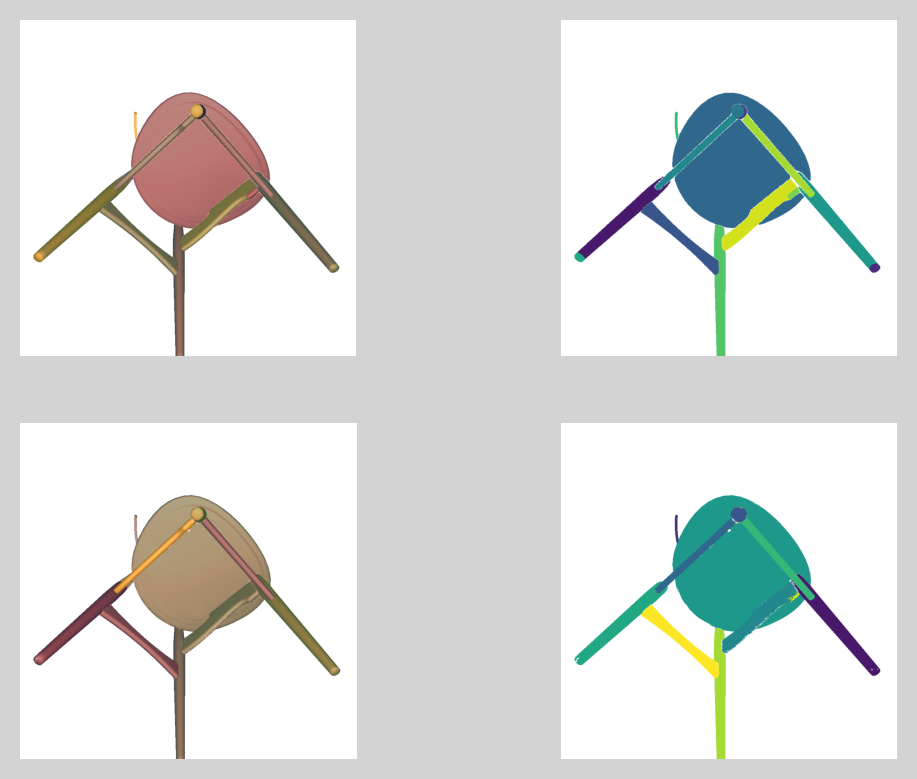

In [37]:
def show_opted(S, index=0, eps=1e-7):
    P = S.softmax(dim=1)
    Masks = (P.T @ faces_masks) / (P.T @ view_masks[view_indices]).clamp_min(eps)
    match_index = P.argmax(dim=1)
    now_mask = Masks[match_index]

    indices = torch.nonzero(view_indices.eq(index))[:, 0]
    # print(utils.show_shape(indices))
    image = data[index]['image'].clip(0, 1)
    old_mask = [all_masks[i.item()] for i in indices]
    new_mask = now_mask[indices] > 0.5
    new_mask = new_mask[:, data[index]['tri_id'].long()]
    # new_mask = new_mask[data[index]['tri_id']]
    # print(utils.show_shape(old_mask, new_mask))

    fig = plt.figure(dpi=200)
    fig.patch.set_color('lightgray')
    plt.subplot(221)
    vis_util.show_masks(image, old_mask)
    plt.subplot(222)
    vis_util.show_masks(None, old_mask)
    plt.subplot(223)
    vis_util.show_masks(image, new_mask)
    plt.subplot(224)
    vis_util.show_masks(None, new_mask)
    plt.show()


index = np.random.randint(len(data))
print('index:', index)
show_opted(S, index)

In [22]:
P = torch.softmax(S, dim=1)
cidx = P.argmax(dim=1)
print(utils.show_shape(cidx))
num = torch.bincount(cidx, minlength=P.shape[1])
print(num)
print(torch.sort(num)[0])
print(torch.kthvalue(num, Lmax // 2)[0])
print(calc_comm_prob(P).mean(dim=0).sort()[0])

LongTensor[1488]
tensor([ 56,  32,  13,  49,  28,  66,  65,  58,  69,  89,  35,  33,  51,  45,
         35,  88,  22,  37,  79, 118,  51,  51,  45,  90,  32, 119,  32],
       device='cuda:0')
tensor([ 13,  22,  28,  32,  32,  32,  33,  35,  35,  37,  45,  45,  49,  51,
         51,  51,  56,  58,  65,  66,  69,  79,  88,  89,  90, 118, 119],
       device='cuda:0')
tensor(119, device='cuda:0')
tensor([0.0740, 0.1446, 0.1625, 0.1731, 0.1971, 0.1992, 0.2169, 0.2316, 0.2401,
        0.2451, 0.3142, 0.3291, 0.3364, 0.3675, 0.3680, 0.3741, 0.3883, 0.3887,
        0.4501, 0.4711, 0.5141, 0.5196, 0.5248, 0.5628, 0.6346, 0.7959, 0.8415],
       device='cuda:0', grad_fn=<SortBackward0>)


index: 89


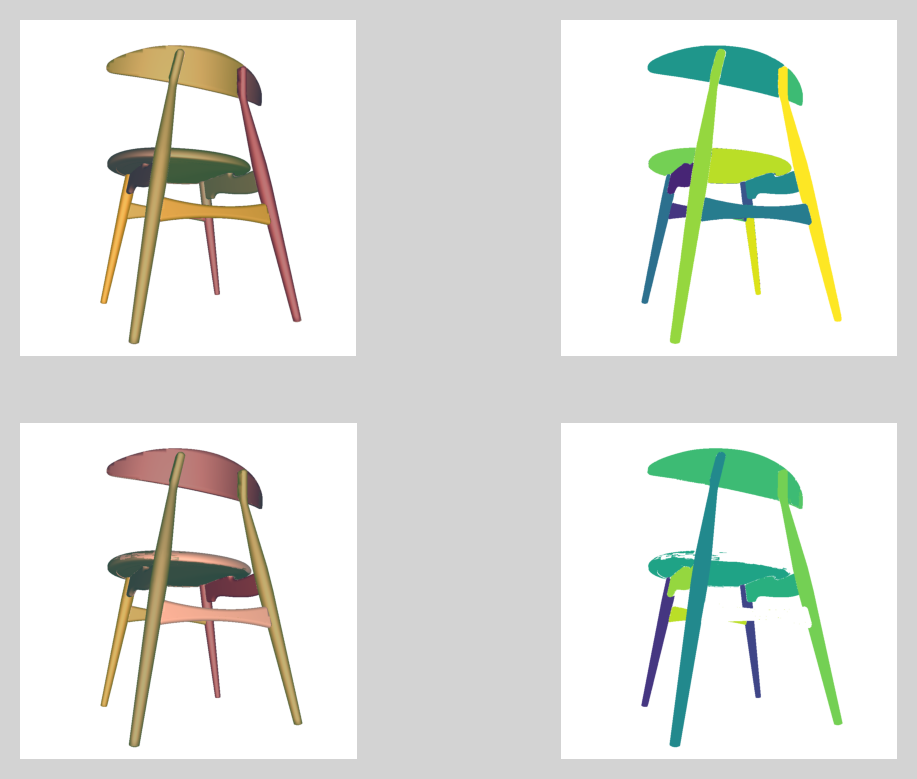

In [23]:
index = np.random.randint(len(data))
print('index:', index)
show_opted(S, index)

index: 96


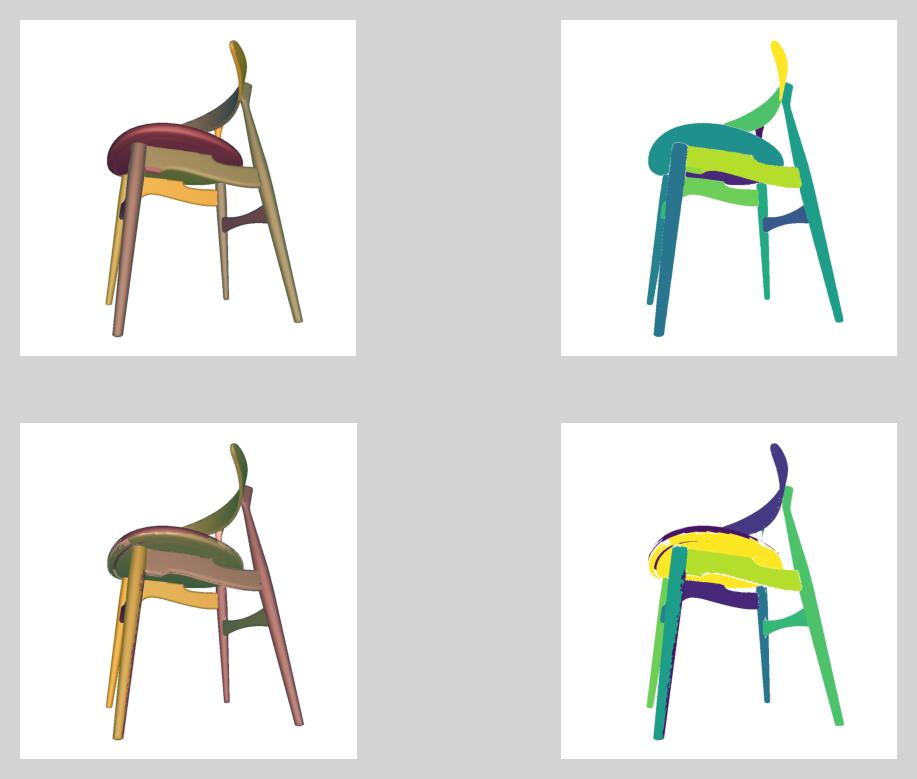

In [24]:
index = np.random.randint(len(data))
print('index:', index)
show_opted(S, index)

index: 36


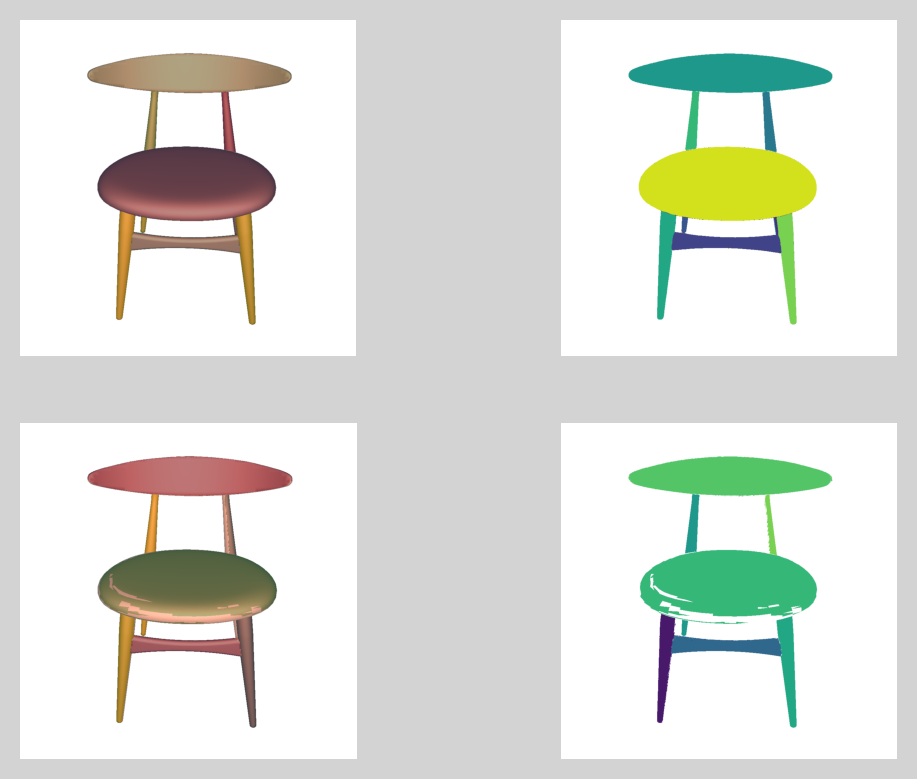

In [25]:
index = np.random.randint(len(data))
print('index:', index)
show_opted(S, index)

index: 57
prediction: BoolTensor[15, 84763]
masks: BoolTensor[15, 1024, 1024]
level 1, num=9:


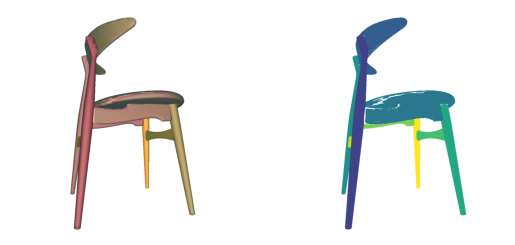

level 2, num=3:


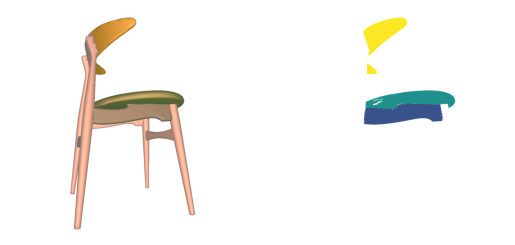

In [54]:
index = np.random.randint(len(data))
print('index:', index)

P = S.softmax(dim=1)
prediction = (P.T @ faces_masks) / (P.T @ view_masks[view_indices]).clamp_min(1e-3) > 0.5
prediction = prediction[Score.sigmoid() >= 0.5, :]
print('prediction:', utils.show_shape(prediction))
masks = prediction[:, data[index]['tri_id'].long()]
print('masks:', utils.show_shape(masks))
tree_data = TreeData(MaskData(masks=masks, iou_preds=torch.zeros(len(masks), device=device)), device=device)
tree_data.update_tree()
tree_data.remove_not_in_tree()

image = data[index]['image'].clip(0, 1)
for level, nodes in enumerate(tree_data.get_levels()):
    if level == 0:
        continue
    # plt.figure(figsize=(10, 5))
    nodes = nodes.long()
    print(f"level {level}, num={len(nodes)}:")
    plt.subplot(121)
    vis_util.show_masks(image, tree_data.data['masks'][nodes - 1])
    plt.subplot(122)
    vis_util.show_masks(None, tree_data.data['masks'][nodes - 1])
    plt.show()

In [55]:
S.requires_grad

True